# Twitter Bot or Not?: Exploratory Data Analysis

Dataset: [Twitter Bot Accounts](https://www.kaggle.com/davidmartngutirrez/twitter-bots-accounts?)


In [1]:
# Basics
import pandas as pd
import numpy as np

# Visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Data import and setup

In [2]:
raw_df = pd.read_csv('data_files/twitter_human_bots_dataset.csv.zip', index_col=False)

In [3]:
raw_df.head()

,Unnamed: 0,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,787405734442958848,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,796216118331310080,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human
2,2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,875949740503859204,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,human
3,3,2016-07-21 13:32:25,True,False,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,True,756119643622735875,en,"Birmingham, AL",NaN,http://pbs.twimg.com/profile_images/1284884924...,TinkerVHELPK5,1324,False,0.889,1489,human
4,4,2012-01-15 16:32:35,False,False,Loan coach at @mancity & Aspiring DJ,88,753678,116,True,464781334,en,"England, United Kingdom",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,True,1.339,3138,human


In [4]:
# drop funny index column
raw_df.drop(columns=['Unnamed: 0'], inplace=True)

# Binary classifications for bots and boolean values
raw_df['bot'] = raw_df['account_type'].apply(lambda x: 1 if x == 'bot' else 0)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile_image'] = raw_df['default_profile_image'].astype(int)
raw_df['geo_enabled'] = raw_df['geo_enabled'].astype(int)
raw_df['verified'] = raw_df['verified'].astype(int)

# datetime conversion
raw_df['created_at'] = pd.to_datetime(raw_df['created_at'])
# hour created
raw_df['hour_created'] = pd.to_datetime(raw_df['created_at']).dt.hour

In [5]:
# usable df setup
df = raw_df[['bot', 'screen_name', 'created_at', 'hour_created', 'verified', 'location', 'geo_enabled', 'lang', 'default_profile', 
              'default_profile_image', 'favourites_count', 'followers_count', 'friends_count', 'statuses_count',
             'average_tweets_per_day', 'account_age_days']]

del raw_df

In [6]:
df.head()

,bot,screen_name,created_at,hour_created,verified,location,geo_enabled,lang,default_profile,default_profile_image,favourites_count,followers_count,friends_count,statuses_count,average_tweets_per_day,account_age_days
0,1,best_in_dumbest,2016-10-15 21:32:11,21,0,unknown,0,en,0,0,4,1589,4,11041,7.870,1403
1,0,CJRubinPhoto,2016-11-09 05:01:30,5,0,Estados Unidos,0,en,0,0,536,860,880,252,0.183,1379
2,0,SVGEGENT,2017-06-17 05:34:27,5,0,"Los Angeles, CA",1,en,0,0,3307,172,594,1001,0.864,1159
3,0,TinkerVHELPK5,2016-07-21 13:32:25,13,0,"Birmingham, AL",1,en,1,0,8433,517,633,1324,0.889,1489
4,0,JoleonLescott,2012-01-15 16:32:35,16,1,"England, United Kingdom",1,en,0,0,88,753678,116,4202,1.339,3138


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37438 entries, 0 to 37437
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   bot                     37438 non-null  int64         
 1   screen_name             37438 non-null  object        
 2   created_at              37438 non-null  datetime64[ns]
 3   hour_created            37438 non-null  int64         
 4   verified                37438 non-null  int64         
 5   location                37435 non-null  object        
 6   geo_enabled             37438 non-null  int64         
 7   lang                    29481 non-null  object        
 8   default_profile         37438 non-null  int64         
 9   default_profile_image   37438 non-null  int64         
 10  favourites_count        37438 non-null  int64         
 11  followers_count         37438 non-null  int64         
 12  friends_count           37438 non-null  int64 

In [8]:
df.describe()

,bot,hour_created,verified,geo_enabled,default_profile,default_profile_image,favourites_count,followers_count,friends_count,statuses_count,average_tweets_per_day,account_age_days
count,37438.000000,37438.000000,37438.000000,37438.000000,37438.000000,37438.000000,37438.000000,3.743800e+04,3.743800e+04,3.743800e+04,37438.000000,37438.000000
mean,0.331882,12.371040,0.201693,0.456141,0.419894,0.014905,12302.062183,3.703098e+05,4.445925e+03,2.107339e+04,6.891668,3022.128052
std,0.470895,7.325433,0.401270,0.498079,0.493548,0.121173,33923.650237,2.470829e+06,4.954520e+04,6.732977e+04,24.580116,1013.695870
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,483.000000
25%,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,362.000000,3.500000e+01,3.700000e+01,1.336250e+03,0.495000,2316.250000
50%,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,2066.000000,3.650000e+02,2.960000e+02,4.209000e+03,1.488000,3219.000000
75%,1.000000,19.000000,0.000000,1.000000,1.000000,0.000000,8879.000000,8.440250e+03,8.930000e+02,1.715375e+04,5.528000,3888.000000
max,1.000000,23.000000,1.000000,1.000000,1.000000,1.000000,885123.000000,1.216415e+08,4.343060e+06,2.771910e+06,1269.055000,5158.000000


## Data transformations for EDA

In [9]:
# Log transformations for highly skewed data
df['friends_log'] = np.round(np.log(1 + df['friends_count']), 3)
df['followers_log'] = np.round(np.log(1 + df['followers_count']), 3)
df['favs_log'] = np.round(np.log(1 + df['favourites_count']), 3)
df['avg_daily_tweets_log'] = np.round(np.log(1+ df['average_tweets_per_day']), 3)

# Possible popularity metrics
df['popularity'] = np.round(df['friends_log'] * df['followers_log'], 3)
df['tweet_to_followers'] = np.round(np.log( 1+ df['statuses_count']) * np.log(1+ df['followers_count']), 3)

# Using age of account to understand acqusition of followers, friends, and favorites
df['follower_acq_rate'] = np.round(np.log(1 + (df['followers_count'] / df['account_age_days'])), 3)
df['friends_acq_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)
df['favs_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)

## Distribution plots

### Account age

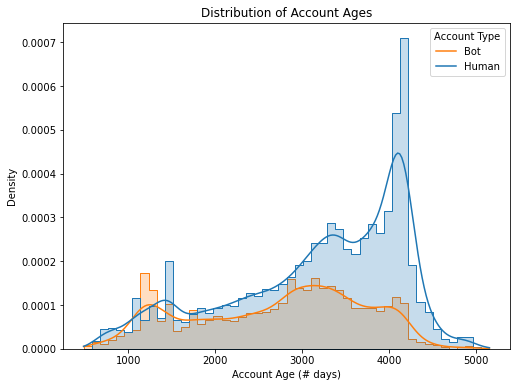

In [10]:
plt.figure(figsize=(8,6))
sns.histplot(x='account_age_days', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Account Age (# days)')
plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'])
plt.title('Distribution of Account Ages');

### Number of followers

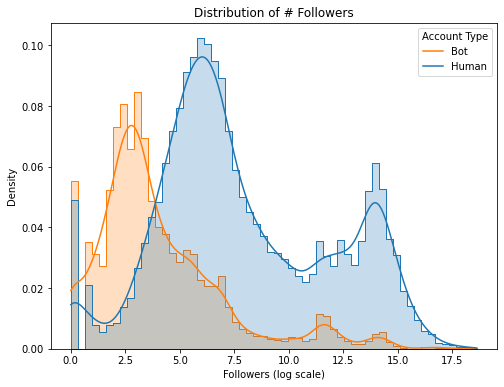

In [11]:
plt.figure(figsize=(8,6))
sns.histplot(x='followers_log', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Followers (log scale)')
plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'])
plt.title('Distribution of # Followers');

### Number of friends (follow*ing*)

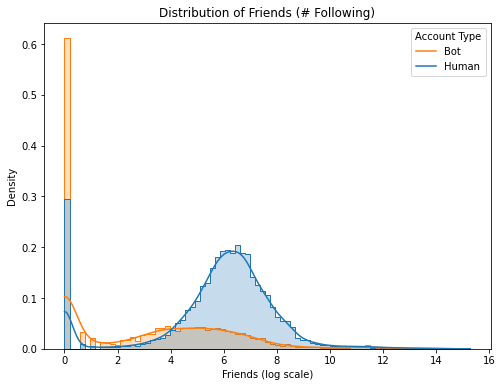

In [12]:
plt.figure(figsize=(8,6))
sns.histplot(x='friends_log', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Friends (log scale)')
plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'])
plt.title('Distribution of Friends (# Following)');

### 'Popularity'

Defined as `(number of friends) * (number of followers)`

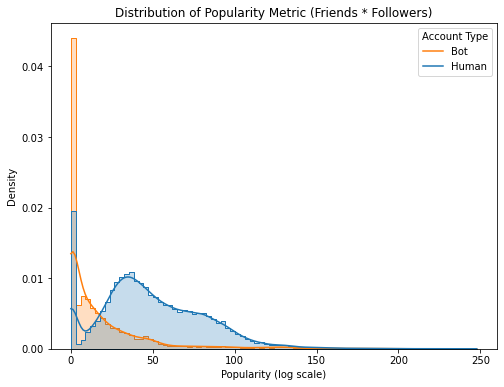

In [13]:
plt.figure(figsize=(8,6))
sns.histplot(x='popularity', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Popularity (log scale)')
plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'])
plt.title('Distribution of Popularity Metric (Friends * Followers)');

### Number of favorites

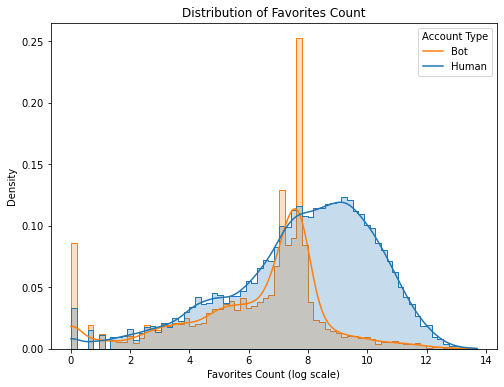

In [14]:
plt.figure(figsize=(8,6))
sns.histplot(x='favs_log', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Favorites Count (log scale)')
plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'])
plt.title("Distribution of Favorites Count");

### Avg tweets per day

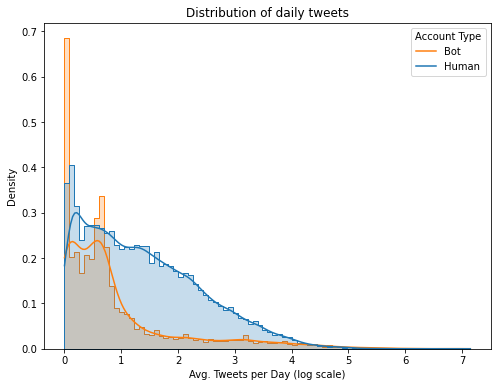

In [15]:
plt.figure(figsize=(8,6))
sns.histplot(x='avg_daily_tweets_log', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Avg. Tweets per Day (log scale)')
plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'])
plt.title("Distribution of daily tweets");

### Follower acquisition rate

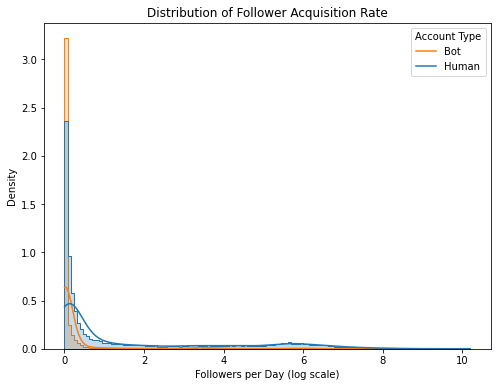

In [16]:
plt.figure(figsize=(8,6))
sns.histplot(x='follower_acq_rate', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Followers per Day (log scale)')
plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'])
plt.title("Distribution of Follower Acquisition Rate");

### Friends acquisition rate

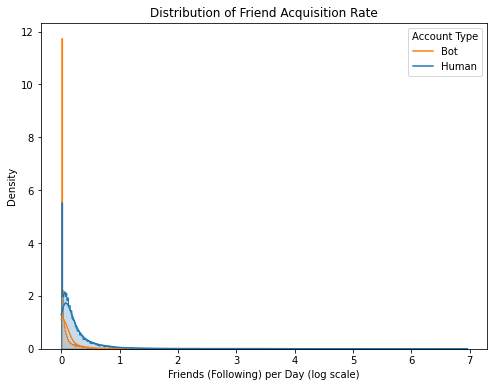

In [17]:
plt.figure(figsize=(8,6))
sns.histplot(x='friends_acq_rate', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Friends (Following) per Day (log scale)')
plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'])
plt.title("Distribution of Friend Acquisition Rate");

### Tweets to followers ratio

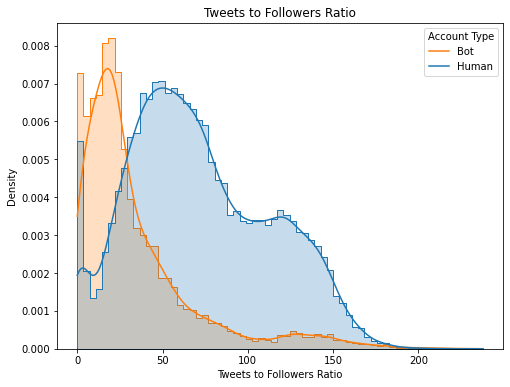

In [18]:
plt.figure(figsize=(8,6))
sns.histplot(x='tweet_to_followers', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Tweets to Followers Ratio')
plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'])
plt.title("Tweets to Followers Ratio");

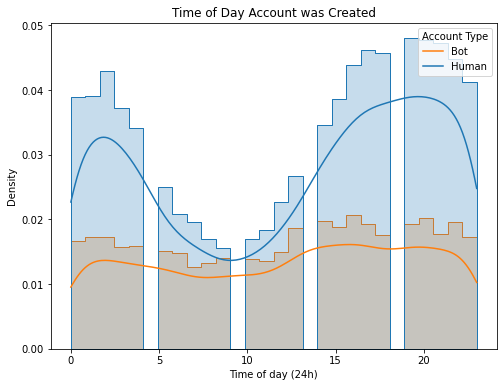

In [21]:
plt.figure(figsize=(8,6))
sns.histplot(x='hour_created', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Time of day (24h)')
plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'])
plt.title("Time of Day Account was Created");

## Correlations

### All data

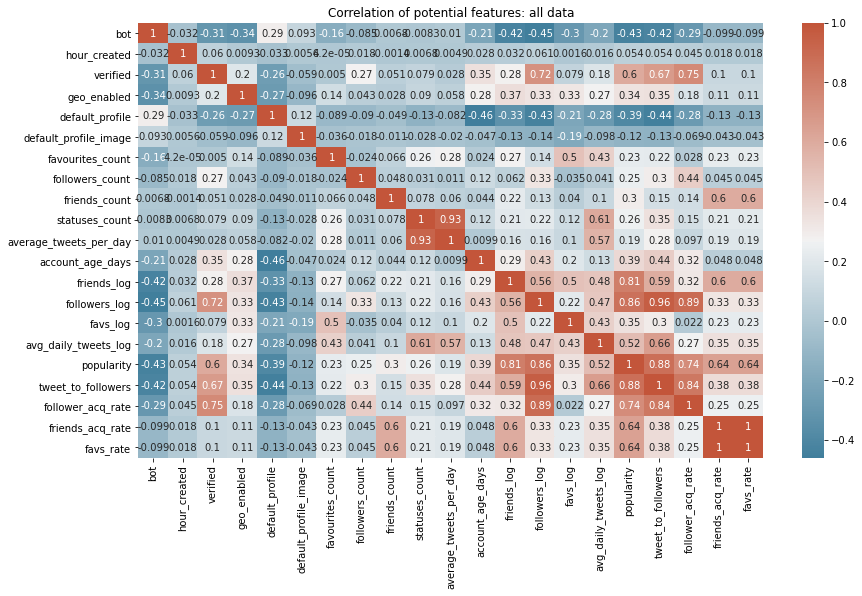

In [22]:
plt.figure(figsize=(14,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df.corr(), cmap=cmap, annot=True)
plt.title('Correlation of potential features: all data');

### Bots vs Humans

In [23]:
bots = df[df['bot'] == 1]
humans = df[df['bot'] == 0]

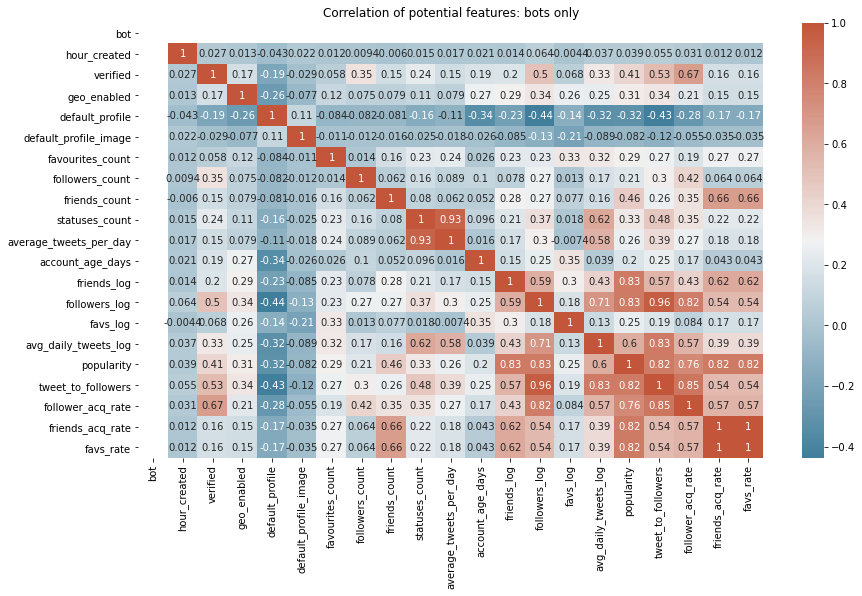

In [24]:
plt.figure(figsize=(14,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(bots.corr(), cmap=cmap, annot=True)
plt.title('Correlation of potential features: bots only');

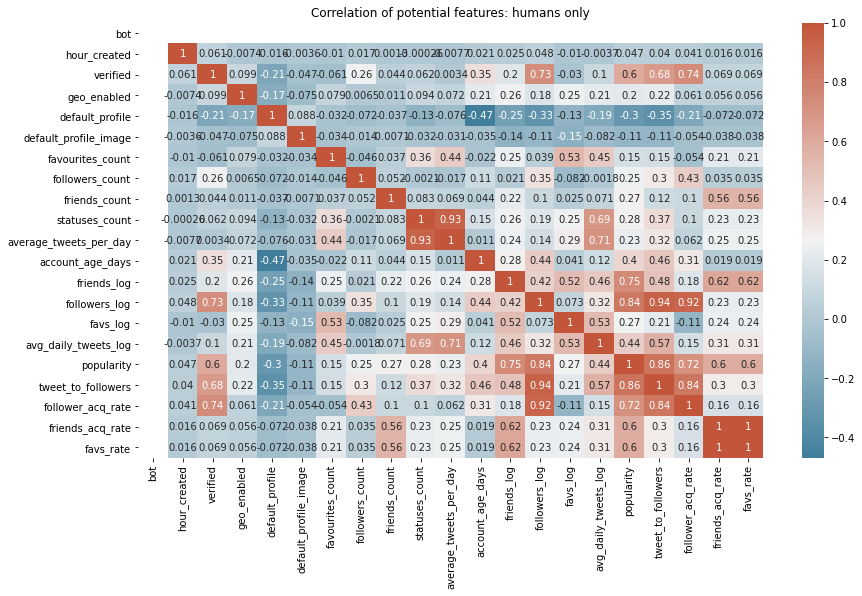

In [25]:
plt.figure(figsize=(14,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(humans.corr(), cmap=cmap, annot=True)
plt.title('Correlation of potential features: humans only');